# Tarea 2
## MA5203 - Aprendizaje de Máquinas Probabilístico
### Nombre: Sebastián Parra

In [1]:
#Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

import easygui

In [2]:
# Funciones importantes

## leerDatos: Lee los datos de un archivo .txt y devuelve los ejes X e Y en forma de arrays de numpy
## input: 
##     filepath - (string) String que indique la ubicación del archivo
## outputs:
##     X - (array) El eje X (la primera columna de datos)
##     Y - (array) El eje Y (la segunda columna de datos)
def leerDatos(filepath):
    #Guardar archivo .txt en dataframe (se asume que los valores están separados por espacios y no tienen header)
    df = pd.read_csv(filepath, delim_whitespace=True, header=None)
    
    X = df.values[:,0] #Obtener vector del eje x
    Y = df.values[:,1] #Obtener vector del eje y
    return X, Y

## graficarDatos: Grafica los conjuntos de entrenamiento y validación
## input: 
##      X_train, X_test - (array) Vectores de entrenamiento y validación en el eje X
##      Y_train, Y_test - (array) Vectores de entrenamiento y validación en el eje Y
def graficarDatos(X_train,X_test,Y_train,Y_test):
    plt.scatter(meses_train, pasajeros_train, s = 4, c = 'r', label='Conjunto de entrenamiento')
    plt.scatter(meses_test, pasajeros_test, s = 4, c = 'b', label='Conjunto de validación')
    plt.xlabel("Meses")
    plt.ylabel("Número de pasajeros transportados")
    plt.title("Gráfico numero de pasajeros v/s mes")
    plt.legend()
    plt.show()
    
## ajustePolinomial: Genera un modelo de regresión no-lineal como un polinomio de grado 'grado'
## input:
##      X: (array) Vector de entradas
##      Y: (array) Vector de observaciones
##      grado: (int) El grado que se desea que tenga el polinomio del ajuste.
##      rho: (float) (opcional) El valor del coeficiente de regularización. Por defecto toma el valor cero.
## output:
##      theta: (array) Vector de coeficientes del polinomio a modelar
def ajustePolinomial(X, Y, grado, rho=0):
    #Inicializar matriz de características
    phi = np.zeros((len(X), grado + 1))

    #Armar matriz de características
    phi[:,0] = 1 #Columna de x ** 0
    for i in range(len(phi)):
        for j in range(grado):
            phi[i][j+1] = X[i]**(j+1)

    #Generar variables auxiliares
    aux1 = np.matmul(np.transpose(phi), phi) + rho * np.identity(grado+1) #Matriz a invertir
    aux2 = np.matmul(np.transpose(phi), np.reshape(Y, (-1,1))) #Resto de la fórmula
    
    #Calcular theta
    theta = np.matmul(np.linalg.inv(aux1), aux2)
    return theta

## generarPredicciones: Genera un vector de predicciones de regresión no lineal polinomial
## a partir de un vector de entrada y un vector de coeficientes polinomiales
## input:
##      X: (array) Vector de entradas
##      theta: (array) Vector de coeficientes polinomiales
## output:
##      prediccion: (array) Vector de predicciones
def generarPredicciones(X, theta):
    prediccion = np.zeros(len(X))
    for i in range(len(theta)):
        prediccion += theta[i]*(X**i)
    return prediccion

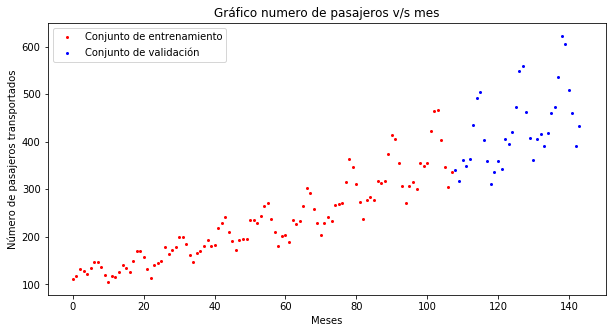

In [3]:
###############################################################################
# Parte 1: Cargar los datos, separar entrenamiento y validación, y graficarlos
###############################################################################

# Cargar archivo .txt y guardar vectores de datos
meses_tot, pasajeros_tot = leerDatos(easygui.fileopenbox("Selecciona el archivo de los datos"))

# Obtener conjuntos de entrenamiento y validación
meses_train, meses_test, pasajeros_train, pasajeros_test = train_test_split(meses_tot, pasajeros_tot,
                                                                            test_size = 0.25, shuffle = False)

# Graficar los datos
plt.figure(figsize=(10,5))
graficarDatos(meses_train,meses_test,pasajeros_train,pasajeros_test)

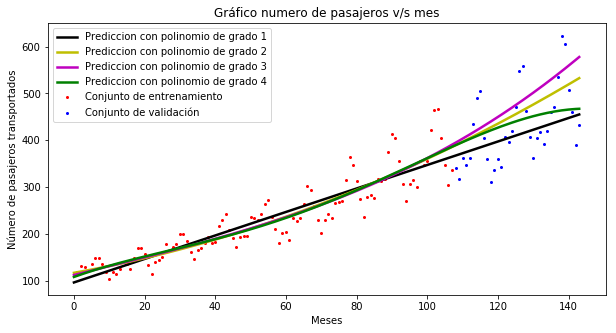

In [4]:
###################################################################################
# Parte 2: Crear ajuste polinomial y graficarlo para distintos grados polinomiales
###################################################################################

#Crear figura
plt.figure(figsize=(10,5))

#Generar lista de códigos de color
colores = ['k','y','m','g']

#Generar predicciones para ajustes con polinomios de grado 1 a 4
for i in range(4):
    theta = ajustePolinomial(meses_train,pasajeros_train, (i+1), 0.3)
    #Generar vector de predicciones
    prediccion = generarPredicciones(meses_tot, theta)
    #Gaficar prediccion
    plt.plot(meses_tot,prediccion, colores[i], linewidth=2.5, label='Prediccion con polinomio de grado ' + str(i+1))
    
#Graficar
graficarDatos(meses_train,meses_test,pasajeros_train,pasajeros_test)

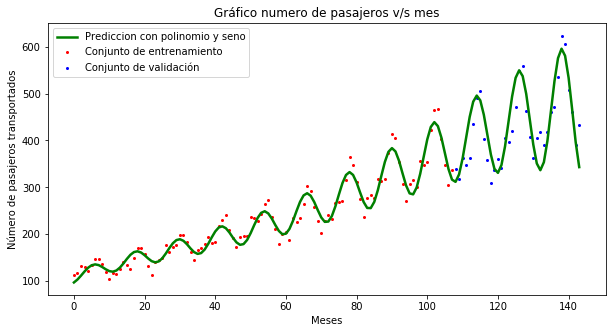

In [5]:
###########################################################
# Parte 3: Agregar primera componente sinusoidal al modelo
###########################################################

#Guardar ajuste con polinomio de grado 4
fpol = prediccion

#Definir función de verosimilitud a minimizar
# input:
#      params: (float) Vector de parámetros del ajuste sinusoidal
# output:
#     (float) El valor de la función
def verosimilitud1(params):
    return sum((pasajeros_train[:] - (fpol[:-len(pasajeros_test)] + params[0] * np.sin(params[1] * meses_train[:] +
                                                        params[2]) * np.exp(params[3] * meses_train[:])) ) ** 2)

#Calcular parámetros del ajuste
theta_sin = np.zeros(4) #Inicializar vector de parámetros
x_init = [3.0, 4.0, 1.0, 0.01] #Crear vector de condiciones iniciales
theta_sin = minimize(verosimilitud1, x_init, method='BFGS', jac=False, tol=1e-12, options={'gtol':1e-6})

#Crear nueva figura
plt.figure(figsize=(10,5))

#Crear nuevo vector de predicciones
prediccion = fpol + theta_sin.x[0] * np.sin(theta_sin.x[1] * meses_tot + 
                                            theta_sin.x[2]) * np.exp(theta_sin.x[3] * meses_tot)

#Graficar predicciones
plt.plot(meses_tot,prediccion, 'g', linewidth=2.5, label='Prediccion con polinomio y seno')
graficarDatos(meses_train,meses_test,pasajeros_train,pasajeros_test)

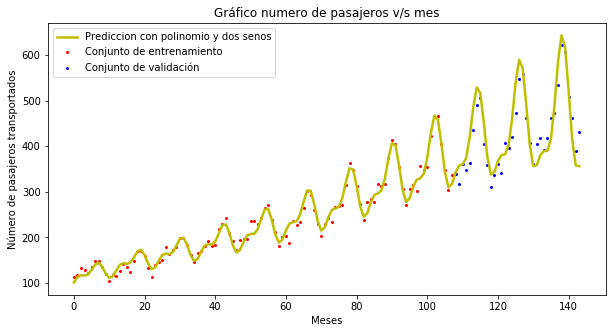

In [6]:
###########################################################
# Parte 4: Agregar segunda componente sinusoidal al modelo
###########################################################

#Guardar ajuste anterior
f_pol_sin = prediccion

#Definir función de verosimilitud a minimizar
# input:
#      params: (float) Vector de parámetros del ajuste sinusoidal
# output:
#     (float) El valor de la función
def verosimilitud2(params):
    return sum((pasajeros_train[:] - (f_pol_sin[:-len(pasajeros_test)] + params[0] * np.sin(params[1] * meses_train[:] +
                                                        params[2]) * np.exp(params[3] * meses_train[:])) ) ** 2)

#Calcular parámetros del ajuste
theta_sin2 = np.zeros(4) #Inicializar vector de parámetros
x_init = [1.0, 1.0, 5.0, 0.01] #Crear vector de condiciones iniciales
theta_sin2 = minimize(verosimilitud2, x_init, method='BFGS', jac=False, tol=1e-12, options={'gtol':1e-6})

#Crear nueva figura
plt.figure(figsize=(10,5))

#Crear nuevo vector de predicciones
prediccion = f_pol_sin + theta_sin2.x[0] * np.sin(theta_sin2.x[1] * meses_tot + 
                                            theta_sin2.x[2]) * np.exp(theta_sin2.x[3] * meses_tot)

#Graficar predicciones
plt.plot(meses_tot,prediccion, 'y', linewidth=2.5, label='Prediccion con polinomio y dos senos')
graficarDatos(meses_train,meses_test,pasajeros_train,pasajeros_test)